# Litteraturbanken Author 
version 1.20 -  added link json 

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
  * video Swedish
* [Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank](https://www.wikidata.org/wiki/Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank)

#### Other sources we sync
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 

#### Misc
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      * Question 
        * ~~how to see [JSON for a record 23](https://github.com/spraakbanken/littb-frontend/issues/23)~~
        * ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~  
          * question if they will have [Persistent Litteraturbanken place id](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author
* [Wikidata properties also available](https://w.wiki/eck) when we have P5101

**The objective** 
1. Find all Litteraturbanken Author objects that has Show True
1. Try to match Wikidata or create a new object for as many authors in Litteraturbanken as possible
  1. lesson learned not all authors are identified by Litteraturbanken --> maybe we should not create everyone in Wikidata or is Wikidata a good place to find relations e.g. [Louise Müller](https://www.wikidata.org/wiki/Q100566908?uselang=sv) same as
     1. Alvin [alvin-person:6474](http://www.alvin-portal.org/alvin/view.jsf?pid=alvin-person:6474)
     1. wife Riksarkivet SBL _J Daniel A Müller_ [id=8596](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=8596) 
     1. VIAF [18128821](https://viaf.org/viaf/18128821/)
        1. LIBRISXL [qn259h685g929bf](https://libris.kb.se/katalogisering/qn259h685g929bf) / [JSON](https://libris.kb.se/qn259h685g929bf/data.jsonld)
1. If Litteraturbanken has identified an author with LIBRIS id and we dont find it in Wikidata we create it

**Lesson learned**
1. we need to filter using Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text see [tweet question](https://twitter.com/salgo60/status/1313834219794296834?s=20)
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning



## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]   

### 2) copyright on metadata?
Should be ok see [JSON for a record 23 comment 707542448](https://github.com/spraakbanken/littb-frontend/issues/23#issuecomment-707542448)

### 3) Persistent indentifiers for Litteraturbanken
Example what Litteraturbanken plans to do see [Facebook](https://www.facebook.com/Litteraturbanken.se/videos/261954861599359)
* suggestion that they use Public identifiers see [question https24#issuecomment-711140342](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2020-11-02 23:40:35.575693


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
#df.head()

In [5]:
#df.info() 
df[df['authorid_norm'].str.contains("BirchPfeifferC")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
376,BirchPfeifferC,BirchPfeifferC,"{'date': '1800', 'plain': '1868'}",a4ba99138da2a29c78a5f39c12fe7649,1603795013039,{'plain': '1800'},author,Charlotte Birch-Pfeiffer,female,2018-10-25,None,NaN,"Birch-Pfeiffer, Charlotte",None,False,False,Birch-Pfeiffer,2019-05-14,"{'birthplace': [9.1775, 48.776111111], 'birthp...",NaN,"{'intro': None, 'intro_author': 'LagercrantzMV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# create a smaller dataset from this
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3730 entries, 0 to 3729
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 3730 non-null   object        
 1   wd_hos_Litteraturbanken  1516 non-null   object        
 2   authorid_norm            3730 non-null   object        
 3   show                     3730 non-null   bool          
 4   updated                  3066 non-null   datetime64[ns]
 5   imported                 3066 non-null   datetime64[ns]
 6   librisid                 1983 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 178.6+ KB


In [7]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
# flag I guess we should use
LitteraturbankenTot["show"].value_counts()

True     2299
False    1431
Name: show, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 1 to 3729
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2299 non-null   object        
 1   wd_hos_Litteraturbanken  1509 non-null   object        
 2   authorid_norm            2299 non-null   object        
 3   show                     2299 non-null   bool          
 4   updated                  1851 non-null   datetime64[ns]
 5   imported                 1851 non-null   datetime64[ns]
 6   librisid                 1224 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 128.0+ KB


In [10]:
#LitteraturbankenTotShow

### Latest updated at Litteraturbanken

In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:10]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,RichterL,NaN,RichterL,True,2020-10-26,2020-10-26,zw9cfmqh4qlv6tc
1,QuenselC,NaN,QuenselC,True,2020-10-26,2020-10-26,xv8cgq5g2xl8d0l
2,SkjöldebrandE,NaN,SkjoldebrandE,True,2020-10-26,2020-10-26,75kmj5fr0m1qgq8
3,LindgrenAnders,Q68255904,LindgrenAnders,True,2020-10-26,2017-11-23,sq47bbtb0r94f12
4,HildebrandA,NaN,HildebrandA,True,2020-10-26,2020-10-26,20dhln2l5slh8fx
5,AurellT,Q959534,AurellT,True,2020-10-26,2019-06-24,fcrtvvpz1wrmx5p
6,ModeerA,NaN,ModeerA,True,2020-10-26,2020-10-26,1zcf9fmk5c50b4c
7,FlodinS,NaN,FlodinS,True,2020-10-26,2020-10-26,0xbd7h2j5lt2363
8,LagerstedtG,NaN,LagerstedtG,True,2020-10-26,2020-10-26,1zcfgqbk239dp2c
9,BibergNF,NaN,BibergNF,True,2020-10-26,2020-10-26,mkz14x950f46s05


### Latest imported at Litteraturbanken

In [54]:
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:30]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,RichterL,NaN,RichterL,True,2020-10-26,2020-10-26,zw9cfmqh4qlv6tc
1,PalmstruchJW,NaN,PalmstruchJW,True,2020-10-26,2020-10-26,1zcgkt8k0khdn76
2,SkjöldebrandE,NaN,SkjoldebrandE,True,2020-10-26,2020-10-26,75kmj5fr0m1qgq8
3,HildebrandA,NaN,HildebrandA,True,2020-10-26,2020-10-26,20dhln2l5slh8fx
4,ModeerA,NaN,ModeerA,True,2020-10-26,2020-10-26,1zcf9fmk5c50b4c
5,LagerstedtG,NaN,LagerstedtG,True,2020-10-26,2020-10-26,1zcfgqbk239dp2c
6,FlodinS,NaN,FlodinS,True,2020-10-26,2020-10-26,0xbd7h2j5lt2363
7,BibergNF,NaN,BibergNF,True,2020-10-26,2020-10-26,mkz14x950f46s05
8,QuenselC,NaN,QuenselC,True,2020-10-26,2020-10-26,xv8cgq5g2xl8d0l
9,OxenstiernaJ,NaN,OxenstiernaJ,True,2020-10-26,2020-10-26,NaN


## Wikidata
query WIkidata for all records with an Littearturbanken Author id

In [13]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# https://w.wiki/ffr
query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [14]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1903 entries, 0 to 1902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  1903 non-null   object
 1   authorid    1903 non-null   object
dtypes: object(2)
memory usage: 29.9+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [15]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    6
authorid      6
dtype: int64

Check if we get LilljegrenJ from Wikidata as Wikidata has a big delay right now 2020-10-08 see 
[Grafana Lag](https://grafana.wikimedia.org/d/000000489/wikidata-query-service?orgId=1&refresh=1m)


In [16]:
WDLittbanktot[WDLittbanktot['authorid'].str.contains("LilljegrenJ")]

,WikidataID,authorid
1067,Q99964978,LilljegrenJ


## Merge Litteraturbanken dataset with Wikidata
Finds if we have a mismatch

In [17]:
#merge 
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
#dfmerge["_merge"].value_counts()   
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)    
dfmerge = dfmerge.sort_values(by=['updated'], ascending=[False])

dfmerge[0:30]  

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
1903,NaN,BergwallJ,NaN,BergwallJ,True,2020-10-26,2020-10-26,NaN,Litterturbanken_only
1345,Q6027107,OlssonJO,Q6027107,OlssonJO,True,2020-10-26,2018-09-24,nl023qm65g7qw0f,both
116,Q1671251,AurellK,NaN,AurellK,True,2020-10-26,2020-10-26,1zcgkz7k4mgmn8d,both
117,Q959534,AurellT,Q959534,AurellT,True,2020-10-26,2019-06-24,fcrtvvpz1wrmx5p,both
1357,Q16945439,OxenstiernaJ,NaN,OxenstiernaJ,True,2020-10-26,2020-10-26,NaN,both
1377,Q3481543,PeringskiöldJ,NaN,PeringskioldJ,True,2020-10-26,2018-05-10,sq468vkb44185sv,both
796,Q5805318,HildebrandA,NaN,HildebrandA,True,2020-10-26,2020-10-26,20dhln2l5slh8fx,both
1002,Q5931522,LagerstedtG,NaN,LagerstedtG,True,2020-10-26,2020-10-26,1zcfgqbk239dp2c,both
186,Q2612272,BergiusPJ,NaN,BergiusPJ,True,2020-10-26,2020-10-26,b8nqqf8v1sg645j,both
1414,Q1126977,QuenselC,NaN,QuenselC,True,2020-10-26,2020-10-26,xv8cgq5g2xl8d0l,both


In [18]:
# WikidataID is Wikidata object
# wd_hos_Litteraturbanken is the Wikidata object at Litteraturbanken 
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1903 to 2343
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1903 non-null   object        
 1   authorid                 2344 non-null   object        
 2   wd_hos_Litteraturbanken  1509 non-null   object        
 3   authorid_norm            2299 non-null   object        
 4   show                     2299 non-null   object        
 5   updated                  1851 non-null   datetime64[ns]
 6   imported                 1851 non-null   datetime64[ns]
 7   librisid                 1224 non-null   object        
 8   WD_Litteraturbanken      2344 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 183.1+ KB


### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas

2. **Litterturbanken_only** skall skapas/matchas i Wikidata särskild om LIBRIS id finns

  2-1. se [mix-and-match katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) för verktyg att koppla ihop
 

In [19]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1858
Litterturbanken_only     441
WD_only                   45
Name: WD_Litteraturbanken, dtype: int64

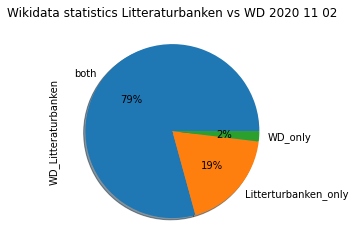

In [20]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [21]:
mergeCheckNumber

both                    1858
Litterturbanken_only     441
WD_only                   45
Name: WD_Litteraturbanken, dtype: int64

### Check diff Wikidata <-> Litteraturbanken were we have LIBRISid

In [22]:
#mergewithLibris

In [23]:
mergewithLibris = dfmerge[dfmerge["librisid"].notnull()].copy() 
#plotmerge = mergewithLibris.plot.pie( \
#                   autopct='%1.0f%%', \
#                   shadow=True, startangle=0, \
#                   title = "Wikidata statistics Litteraturbanken with LIBRIS " + start_time.strftime('%Y %m %d'))
#plotmerge.plot( kind = 'bar',subplots=True) 
#plt.title("LIBRIS ")
#plt.savefig('LitteraturbankenWDLibris.png')
#plt.show()


In [24]:
mergewithLibris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224 entries, 1345 to 1434
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1223 non-null   object        
 1   authorid                 1224 non-null   object        
 2   wd_hos_Litteraturbanken  987 non-null    object        
 3   authorid_norm            1224 non-null   object        
 4   show                     1224 non-null   object        
 5   updated                  1224 non-null   datetime64[ns]
 6   imported                 1224 non-null   datetime64[ns]
 7   librisid                 1224 non-null   object        
 8   WD_Litteraturbanken      1224 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 95.6+ KB


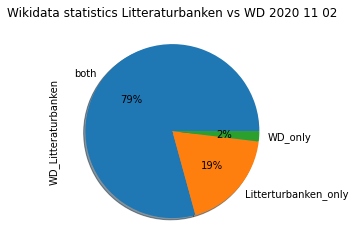

In [25]:


mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [26]:
mergeCheckNumber

both                    1858
Litterturbanken_only     441
WD_only                   45
Name: WD_Litteraturbanken, dtype: int64

In [27]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 14 to 1894
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               45 non-null     object        
 1   authorid                 45 non-null     object        
 2   wd_hos_Litteraturbanken  0 non-null      object        
 3   authorid_norm            0 non-null      object        
 4   show                     0 non-null      object        
 5   updated                  0 non-null      datetime64[ns]
 6   imported                 0 non-null      datetime64[ns]
 7   librisid                 0 non-null      object        
 8   WD_Litteraturbanken      45 non-null     object        
dtypes: datetime64[ns](2), object(7)
memory usage: 3.5+ KB


In [28]:
LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2299 non-null   object        
 1   wd_hos_Litteraturbanken  1509 non-null   object        
 2   authorid_norm            2299 non-null   object        
 3   show                     2299 non-null   bool          
 4   updated                  1851 non-null   datetime64[ns]
 5   imported                 1851 non-null   datetime64[ns]
 6   librisid                 1224 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 110.1+ KB


In [29]:
wdonly_norm = pd.merge(wdonly, LitteraturbankenTotShow,how='outer', left_on='authorid', right_on='authorid_norm',indicator=True)
wdonly_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 45 non-null     object        
 1   authorid_x                 45 non-null     object        
 2   wd_hos_Litteraturbanken_x  0 non-null      object        
 3   authorid_norm_x            0 non-null      object        
 4   show_x                     0 non-null      object        
 5   updated_x                  0 non-null      datetime64[ns]
 6   imported_x                 0 non-null      datetime64[ns]
 7   librisid_x                 0 non-null      object        
 8   WD_Litteraturbanken        45 non-null     object        
 9   authorid_y                 2299 non-null   object        
 10  wd_hos_Litteraturbanken_y  1509 non-null   object        
 11  authorid_norm_y            2299 non-null   object        
 12  show_y

In [30]:
#df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 

In [31]:
#df[df['authorid'].str.contains("SimonsenM")] 

In [32]:
# has other_name = Malan Simonsen --> SimonsenM redirect to MarnersdóttirM
#df[df['authorid'].str.contains("MarnersdóttirM")] 

1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [33]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


,authorid_x,authorid_y,WikidataID,show_y
0,DahlenT,DahlénT,Q99771903,True
1,FjortoftK,FjørtoftK,Q99871759,True
2,HagstromT,HagströmT,Q100235624,True
3,OstinO,ÖstinO,Q100752816,True
4,StaelvonHolsteinAL,StaëlvonHolsteinAL,Q31872554,True
5,StalmarckT,StålmarckT,Q64220930,True
6,TaubelCG,TäubelCG,Q95794561,True


In [34]:
from IPython.display import HTML
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"].copy()  
wddelete["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + wddelete["authorid"] + "'>link</a>"
pd.set_option("display.max.columns", None) 
HTML(wddelete[{"Littbank","WikidataID","authorid"}].to_html(escape=False))

,authorid,WikidataID,Littbank
14,AfzeliusAJ,Q5543245,link
76,AndrénV,Q5556719,link
118,AurénJA,Q5562560,link
176,BerggrenH,Q100776235,link
213,BirchPfeifferC,Q68117,link
229,BjörkmanE,Q11859217,link
324,ButenschönA,Q14932468,link
374,ChristiernssonH,Q5608546,link
412,DahlenT,Q99771903,link
441,DobbinL,Q100414371,link


In [35]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [36]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 7 non-null      object        
 1   authorid_x                 7 non-null      object        
 2   wd_hos_Litteraturbanken_x  0 non-null      object        
 3   authorid_norm_x            0 non-null      object        
 4   show_x                     0 non-null      object        
 5   updated_x                  0 non-null      datetime64[ns]
 6   imported_x                 0 non-null      datetime64[ns]
 7   librisid_x                 0 non-null      object        
 8   WD_Litteraturbanken        7 non-null      object        
 9   Littbank                   7 non-null      object        
 10  authorid_y                 7 non-null      object        
 11  wd_hos_Litteraturbanken_y  7 non-null      object        
 12  authorid_nor

In [37]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,wd_hos_Litteraturbanken_x,authorid_norm_x,show_x,updated_x,imported_x,librisid_x,WD_Litteraturbanken,Littbank,authorid_y,wd_hos_Litteraturbanken_y,authorid_norm_y,show_y,updated_y,imported_y,librisid_y,_merge
0,Q99771903,DahlenT,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,DahlénT,Q99771903,DahlenT,True,2018-01-18,2018-01-18,NaN,both
1,Q99871759,FjortoftK,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,FjørtoftK,Q99871759,FjortoftK,True,2014-03-14,2014-03-14,NaN,both
2,Q100235624,HagstromT,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,HagströmT,Q100235624,HagstromT,True,2014-01-20,2014-01-20,NaN,both
3,Q100752816,OstinO,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,ÖstinO,Q100752816,OstinO,True,NaT,NaT,NaN,both
4,Q31872554,StaelvonHolsteinAL,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,StaëlvonHolsteinAL,Q31872554,StaelvonHolsteinAL,True,NaT,NaT,NaN,both


In [38]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### Check items not matched to Wikidata but has Librisid

In [39]:
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1858
Litterturbanken_only     441
WD_only                   45
Name: WD_Litteraturbanken, dtype: int64

In [40]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
#Litterturbanken_only.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 1903 to 2343
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               0 non-null      object        
 1   authorid                 441 non-null    object        
 2   wd_hos_Litteraturbanken  11 non-null     object        
 3   authorid_norm            441 non-null    object        
 4   show                     441 non-null    object        
 5   updated                  195 non-null    datetime64[ns]
 6   imported                 195 non-null    datetime64[ns]
 7   librisid                 1 non-null      object        
 8   WD_Litteraturbanken      441 non-null    object        
dtypes: datetime64[ns](2), object(7)
memory usage: 34.5+ KB


In [41]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

WikidataID                 0
authorid                   1
wd_hos_Litteraturbanken    1
authorid_norm              1
show                       1
updated                    1
imported                   1
librisid                   1
WD_Litteraturbanken        1
dtype: int64

## Errors funna nedan 
* Show True borde det inte vara False?: Eugénie BerglindhU EngeströmL Rafael WestinF 
* Dublett: NordinCG / NordinC , ArfvidssonN / ArfwidssonN 
* [SimonsenM](https://litteraturbanken.se/f%C3%B6rfattare/SimonsenM) är lite udda med en se [Malan Marnersdóttir](https://litteraturbanken.se/f%C3%B6rfattare/Marnersd%C3%B3ttirM/titlar) 
  * undran hur ser jag det i datat
  
Skapar en task på GITHUB         
* ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~


In [42]:
#Litterturbanken_only.head()

In [43]:
Litterturbanken_onlyW = Litterturbanken_only[Litterturbanken_only['librisid'].notnull()][{'WikidataID','authorid','WD_Litteraturbanken','librisid','show'}].copy() 
Litterturbanken_onlyW["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + Litterturbanken_only["authorid"] + "'>link Litteraturbanken</a>"
Litterturbanken_onlyW["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + Litterturbanken_only["authorid"] + "'>json</a>"
HTML(Litterturbanken_onlyW.to_html(escape=False))


,authorid,WikidataID,show,WD_Litteraturbanken,librisid,Littbank,LittbankJSON
2050,ArfvidssonN,NaN,True,Litterturbanken_only,hftwzq01397wbbd,link Litteraturbanken,json


In [44]:
#df[df['authorid_norm'].str.contains("ArfvidssonN")] 

In [45]:
#df[df['authorid_norm'].str.contains("ArfwidssonN")] 

### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata 

* Looks like we have some oddities in the Litteraturbanken data as items with Show False looks ok to use see [tweet](https://twitter.com/salgo60/status/1313834219794296834?s=20)

In [46]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [47]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

left_only     1868
right_only    1396
both            35
Name: _merge, dtype: int64

In [48]:
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"].copy() 
del dfmergeDeleteBoth['_merge']
dfmergeDeleteBoth["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + dfmergeDeleteBoth["authorid"] + "'>link Litteraturbanken</a>"
dfmergeDeleteBoth["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + dfmergeDeleteBoth["authorid"] + "'>json</a>"
dfmergeDeleteBoth["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + dfmergeDeleteBoth["WikidataID"] + "'>WD</a>"
HTML(dfmergeDeleteBoth.to_html(escape=False))
# list ok but has Show False

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata
14,Q5543245,AfzeliusAJ,NaN,AfzeliusAJ,False,2022-02-22,2022-02-22,vs6895cd54hmhjz,link Litteraturbanken,json,WD
76,Q5556719,AndrénV,NaN,AndrenV,False,2019-10-16,2014-02-11,31fhkwkm15ph5nn,link Litteraturbanken,json,WD
118,Q5562560,AurénJA,NaN,AurenJA,False,2022-02-22,2022-02-22,zw9cft5h567l1vj,link Litteraturbanken,json,WD
176,Q100776235,BerggrenH,Q100776235,BerggrenH,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
213,Q68117,BirchPfeifferC,Q68117,BirchPfeifferC,False,2019-05-14,2018-10-25,NaN,link Litteraturbanken,json,WD
229,Q11859217,BjörkmanE,NaN,BjorkmanE,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
324,Q14932468,ButenschönA,NaN,ButenschonA,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
374,Q5608546,ChristiernssonH,NaN,ChristiernssonH,False,2022-02-22,2022-02-22,khw04mk30xcmlzs,link Litteraturbanken,json,WD
441,Q100414371,DobbinL,Q100414371,DobbinL,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
624,Q5748259,FåhræusOI,NaN,FahraeusOI,False,2022-02-22,2022-02-22,31fjn5bm30ktpr2,link Litteraturbanken,json,WD


In [49]:
dfmergeDeleteBoth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 14 to 1894
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               35 non-null     object        
 1   authorid                 35 non-null     object        
 2   wd_hos_Litteraturbanken  6 non-null      object        
 3   authorid_norm            35 non-null     object        
 4   show                     35 non-null     object        
 5   updated                  33 non-null     datetime64[ns]
 6   imported                 33 non-null     datetime64[ns]
 7   librisid                 18 non-null     object        
 8   Littbank                 35 non-null     object        
 9   LittbankJSON             35 non-null     object        
 10  Wikidata                 35 non-null     object        
dtypes: datetime64[ns](2), object(9)
memory usage: 3.3+ KB


In [50]:
#List I think shouldnt have Show False in LItteraturbanken

ErrorShowFalseLitteraturbank = pd.DataFrame(['BirchPfeifferC','BjörkmanE','ButenschönA','RomanusAlfvénAC','SjödinS',
                                    'TirénG','ÅströmP','AndrénV','DobbinL','HallbergP','JonssonErnst',
                                    'WästbergA','LundströmM','WästbergA','NordlingS','BerggrenH'
                                            ],columns =['authorid'])
# Get list without errors
dfmergeDeleteCorrected = pd.merge(dfmergeDeleteBoth, ErrorShowFalseLitteraturbank,how='outer', on='authorid',indicator=True)
#HTML(dfmergeDeleteCorrected.to_html(escape=False))

## List to check
Indicates 
1. if we have objects with Show False in WIkidata or
1. Litteraturbanken has objects with books but has Show False

see also ErrorShowFalseLitteraturbank

In [51]:
# Should be empty else delete in Wikidata or add to ErrorShowFalseLitteraturbank
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="left_only"].to_html(escape=False))

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge
0,Q5543245,AfzeliusAJ,NaN,AfzeliusAJ,False,2022-02-22,2022-02-22,vs6895cd54hmhjz,link Litteraturbanken,json,WD,left_only
2,Q5562560,AurénJA,NaN,AurenJA,False,2022-02-22,2022-02-22,zw9cft5h567l1vj,link Litteraturbanken,json,WD,left_only
7,Q5608546,ChristiernssonH,NaN,ChristiernssonH,False,2022-02-22,2022-02-22,khw04mk30xcmlzs,link Litteraturbanken,json,WD,left_only
9,Q5748259,FåhræusOI,NaN,FahraeusOI,False,2022-02-22,2022-02-22,31fjn5bm30ktpr2,link Litteraturbanken,json,WD,left_only
10,Q4971348,GyllenhaalM,NaN,GyllenhaalM,False,2022-02-22,2022-02-22,ljx030j41d0zf20,link Litteraturbanken,json,WD,left_only
11,Q3560997,HagforsJF,NaN,HagforsJF,False,2022-02-22,2022-02-22,b8nqrljv28z6jnr,link Litteraturbanken,json,WD,left_only
13,Q1796212,HansenHP,NaN,HansenHP,False,2022-02-22,2022-02-22,NaN,link Litteraturbanken,json,WD,left_only
15,Q101038205,JuringiusJP,NaN,JuringiusJP,False,2022-02-22,2022-02-22,zw9cg9hh413fwpw,link Litteraturbanken,json,WD,left_only
16,Q52925,KarlXV,NaN,KarlXV,False,2022-02-22,2022-02-22,53hkllwp3l51gpr,link Litteraturbanken,json,WD,left_only
17,Q19976158,KjellstrandJF,NaN,KjellstrandJF,False,2022-02-22,2022-02-22,c9prvr8w38k4gbz,link Litteraturbanken,json,WD,left_only


In [52]:
# Indicates that trhis memeber shouldnt be dfmergeDeleteCorrected
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="right_only"].to_html(escape=False))

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge


In [53]:
end = datetime.now()
print("Ended: ", end)a 
print('Time elapsed (hh:mm:ass.ms) {}'.format(datetime.now() - start_time))

SyntaxError: invalid syntax (<ipython-input-53-7332fdfef551>, line 2)